In [1]:
import matplotlib.pyplot as plt
import numpy as np
import phoebe

In [2]:
t, y, yerr = np.loadtxt('data/photometry/adra_sap_spline_corrected.txt', usecols=(0,1,2)).T
t0_guess = t[np.argmin(y)]

%run setup.py

In [3]:
t0_guess = t[np.argmin(y)]

spacing = 0.4

y_transit = y[(t > t0_guess-spacing) & (t < t0_guess+spacing)]
t_transit = t[(t > t0_guess-spacing) & (t < t0_guess+spacing)]
yerr_transit = yerr[(t > t0_guess-spacing) & (t < t0_guess+spacing)]

t1_guess = t[t>1700][np.argmin(y[t>1700])]
y_transit2 = y[(t > t1_guess-spacing) & (t < t1_guess+spacing)]
t_transit2 = t[(t > t1_guess-spacing) & (t < t1_guess+spacing)]
yerr_transit2 = yerr[(t > t1_guess-spacing) & (t < t1_guess+spacing)]

t2_guess = t[(t>1700) & (t<1740)][np.argmin(y[(t>1700) & (t<1740)])]
y_transit3 = y[(t > t2_guess-spacing) & (t < t2_guess+spacing)]
t_transit3 = t[(t > t2_guess-spacing) & (t < t2_guess+spacing)]
yerr_transit3 = yerr[(t > t2_guess-spacing) & (t < t2_guess+spacing)]

y_transit /= np.max(y_transit)
y_transit2 /= np.max(y_transit2)
y_transit3 /= np.max(y_transit3)

In [4]:
full_transit_time, full_transit_flux, full_transit_err = np.hstack([t_transit, t_transit2, t_transit3]), np.hstack([y_transit, y_transit2, y_transit3]), np.hstack([yerr_transit, yerr_transit2, yerr_transit3])
sort = np.argsort(full_transit_time)
full_transit_time = full_transit_time[sort][::20]
full_transit_flux = full_transit_flux[sort][::20]
full_transit_err = full_transit_err[sort][::20]

In [5]:
time, flux, flux_err = full_transit_time, full_transit_flux, full_transit_err

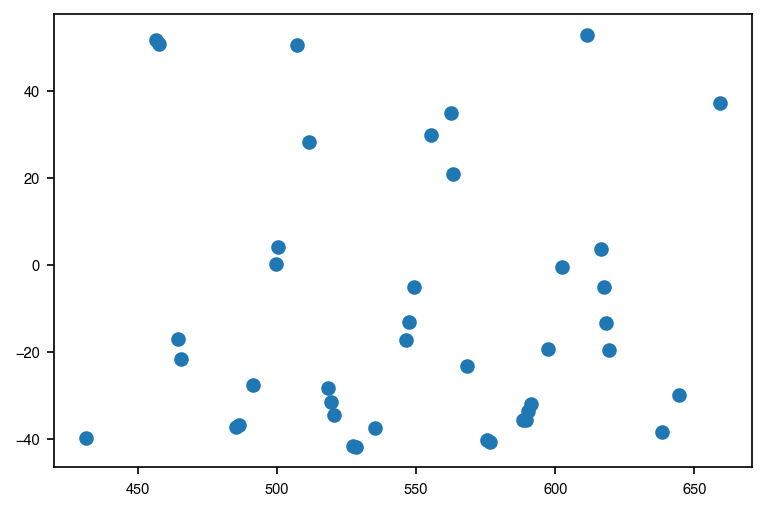

In [6]:
rv_time, rv_rv, rv_err = np.loadtxt('data/RV/bischoff_rv_fixed_time.txt', usecols=(0,1,2)).T
plt.scatter(rv_time, rv_rv)

In [7]:
# Our humble phoebe bundle
b = phoebe.default_binary()

# Let's add our primary transit, and set things to be dataset scaled
b.add_dataset('lc', times=full_transit_time, fluxes=full_transit_flux, dataset='full_lc')
b.add_dataset('rv', times=rv_time, rv=rv_rv, dataset='full_rv')
b.set_value_all('rv_method@full_rv@compute', 'dynamical')

b['pblum_mode'] = 'dataset-scaled'

b.flip_constraint('esinw', solve_for='ecc')
b.flip_constraint('ecosw', solve_for='per0')

phoebe.interactive_constraints_off()
b.get_parameter(context='compute', qualifier='irrad_method').set_value("none")
b.get_parameter(context='compute', component='primary', qualifier='ntriangles').set_value(300)
b.get_parameter(context='compute', component='secondary', qualifier='ntriangles').set_value(300)

In [8]:
bounds = [
    (51., 53.), 
    (0.05, 0.09),
    (0.3,0.6),
    (80,90),
    (9000,12000),
    (0.5,1.),
    (t0_guess-1, t0_guess+1),
    (0.35, 0.41),
    (0.1, 0.2),
    (80, 90),
    (-20, -10),
    (-10, 10),
    (-10, 10)
]

# params = [51.472162, 0.0703, 0.4489, 86.3789, 10100, 0.878, t0_guess, 0.39553, 0.1582,87.4165, -13.498, 0., 0.]
params = [5.14208801e+01,  6.53672682e-02,  3.26921733e-01,  8.69506633e+01,
        1.07215311e+04,  7.66389500e-01,  1.69597369e+03,  3.96021099e-01,
        1.58125340e-01,  8.75288728e+01, -1.34438873e+01, -5.54193346e+00,
       -7.02209935e+00]
lc_x, lc_y, lc_yerr, rv_x, rv_y, rv_yerr = time, flux, flux_err, rv_time, rv_rv, rv_err

In [9]:
def model(params):
    period, rsum, rratio, incl, teff, tratio, t0, ecosw, esinw, sma, gammav, loglc, logrv = params
    
    b['esinw'] = esinw
    b['ecosw'] = ecosw
    b['incl@binary'] = incl
    b['sma@component@orbit'] = sma
    b['teff@primary'] = teff
    b['period@orbit'] = period
    b['t0_supconj'] = t0_guess
    b['requiv@primary'] = b['value@sma@binary']*rsum/(1.+rratio)
    b['requiv@secondary'] = b['value@sma@binary']*rsum*rratio/(1.+rratio)
    b['teff@secondary'] = tratio*b['value@teff@primary']
    
    b.run_compute(irrad_method='none')
    return  b["fluxes@full_lc@phoebe01@latest@lc@model"].value, b["full_rv@model@primary@rvs@latest"].value + gammav

def lnprior(params):
    for param, bound in zip(params, bounds):
        if not (bound[0] < param < bound[1]):
            return -np.inf
    return 0.

def lnlike(params):
    period, rsum, rratio, incl, teff, tratio, t0, ecosw, esinw, sma, gammav, loglc, logrv = params
    lp = lnprior(params)
    if not np.isfinite(lp):
        return -np.inf
    try:
        model_flux, model_rv = model(params)
    except:
        return -np.inf
    
    # LC
    sigma2 = lc_yerr ** 2+ model_flux ** 2 * np.exp(2 * loglc)
    ln_lc = -0.5*np.sum((lc_y-model_flux)**2/sigma2 + np.log(sigma2))
    # RV
    sigma2 = rv_yerr ** 2 + model_rv ** 2 * np.exp(2 * logrv)
    ln_rv = -0.5*np.sum((rv_y-model_rv)**2/sigma2 + np.log(sigma2))
    print(ln_lc + ln_rv)
    return ln_lc + ln_rv


def costfunc(params):
    period, rsum, rratio, incl, teff, tratio, t0, ecosw, esinw, sma, gammav, loglc, logrv = params
    lp = lnprior(params)
    if not np.isfinite(lp):
        return np.inf
    try:
        model_flux, model_rv = model(params)
    except:
        return np.inf
    
    # LC
    sigma2 = lc_yerr ** 2+ model_flux ** 2 * np.exp(2 * loglc)
    ln_lc = -0.5*np.sum((lc_y-model_flux)**2/sigma2 + np.log(sigma2))
    # RV
    sigma2 = rv_yerr ** 2 + model_rv ** 2 * np.exp(2 * logrv)
    ln_rv = -0.5*np.sum((rv_y-model_rv)**2/sigma2 + np.log(sigma2))
    print(ln_lc + ln_rv)
    return -(ln_lc + ln_rv)

nll = lambda *args: -lnlike(*args)

In [10]:
# params = np.array([5.142033815679783260e+01,
# 6.404102313368854882e-02,
# 3.134624448178072176e-01,
# 8.707173868381178750e+01,
# 1.089074003055245521e+04,
# 7.233067757807561948e-01,
# 1.695048360509022359e+03,
# 3.957241432696461114e-01,
# 1.621953189627322045e-01,
# 8.753747013367238594e+01,
# -1.345836463541015782e+01,
# -5.683145333032522117e+00,
# -7.023316870889897423e+00,])
ff, frv = model(params)

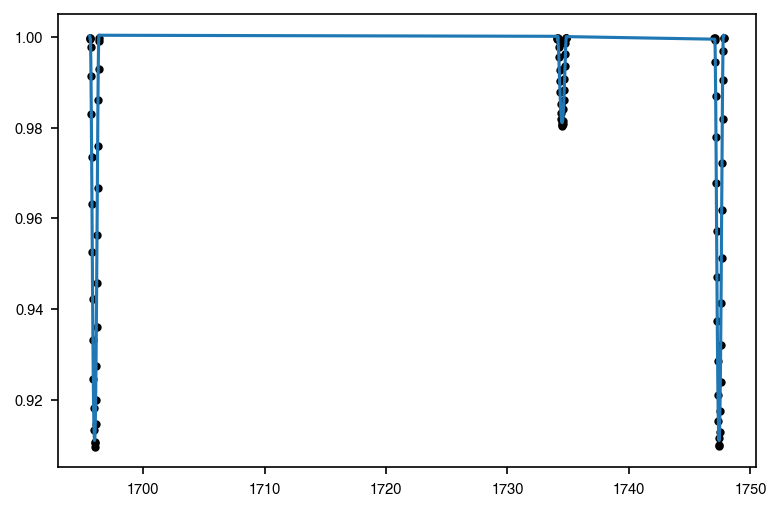

In [13]:
plt.plot(time, ff, zorder=50)
plt.plot(time, flux, '.k', zorder=5)

In [10]:
from multiprocessing import Pool
import emcee
import time

pos = params + 1e-4*np.random.randn(32, len(params))
nwalkers, ndim = pos.shape

with Pool(4) as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnlike, pool=pool)
    start = time.time()
    sampler.run_mcmc(pos, 1, progress=True);
    end = start = time.time()
    multi_time = end - start

-136.1958132720217
-136.28393685263583
-136.09290466865824
-136.24520593099894
-136.02670251355988
-136.38544751390634
-136.45375430829327
-136.30577936033308
-136.28798724046968
-136.19599625501232
-136.00345630183597
-136.27832156549565
-136.0999619712523
-136.06027136698236
-136.04413308260632
-136.1322654092497
-136.14256207009285
-136.18958412872377
-136.30088355131483
-136.13659220197772
-136.18215238737673
-136.08464157568807
-136.13894287307076
-136.05476839263412
-136.16655254411012
-136.0665302718986
-136.19945069264398
-136.1852018480462
-136.3195831723943
-136.10043030529172
-136.33088933347537
-136.1472645659423


  0%|          | 0/1 [00:00<?, ?it/s]

-136.02008953505216
-136.28547900800606
-136.28664223508116
-136.31730420340907
-136.24809272059588
-136.31283989035407
-136.13764966230883
-135.93490454740456
-136.13876113069827
-136.06688058252448
-136.10711135909506
-136.1703200342832
-136.34692019140047
-136.21663387456516
-136.3168741577109
-136.16947082731247
-136.1847368259624
-136.37186433511138
-136.10860522294675
-136.0447893573032
-136.3746301453526
-135.94090813841504
-136.0554797625322
-136.2649588927574
-136.15037813398723
-136.04268614213777
-136.11476231913673
-136.19474320703918


  0%|          | 0/1 [02:10<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
lnlike(params, time, flux, flux_err, rv_time, rv_rv, rv_err)

-74741.59158912953
76.76256792361553
-638.7762179246292
-952670.453386172
-26076.579458752327
-144655.89279875113
-800.4622045179223
-409.73047533209217


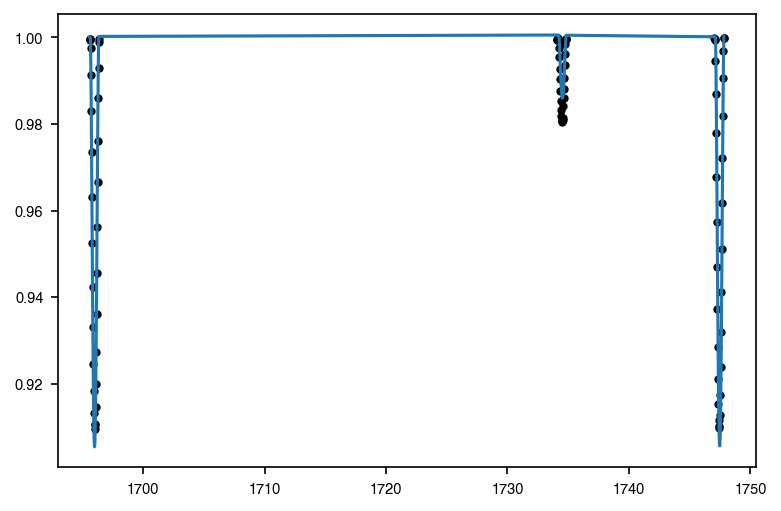

In [109]:
plt.plot(time, flux, '.k')
plt.plot(time, mod_lc)

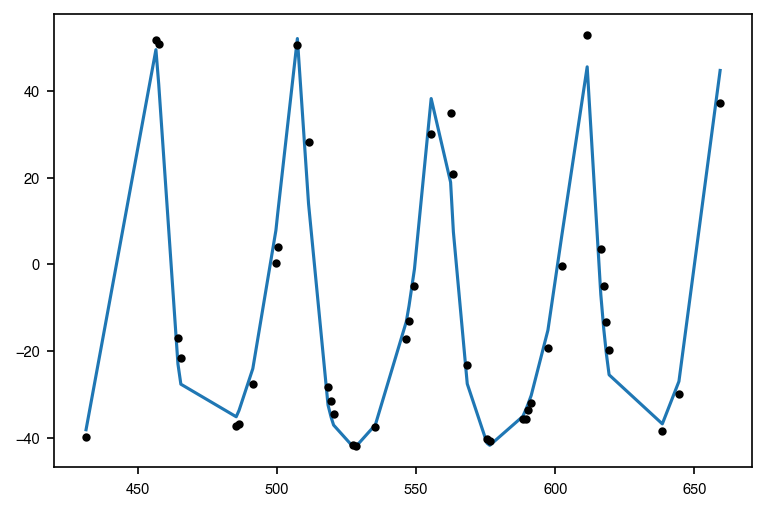

In [103]:
plt.plot(rv_time, mod_rv)
plt.plot(rv_time, rv_rv, '.k')

In [84]:
tratio = 0.878
rsum = 0.0703
rratio = 0.4489

b['esinw'] = 0.15820269794440003
b['ecosw'] = 0.39553
b['incl@binary'] = 86.3789
b['sma@component@orbit'] = 87.4165
b['teff@primary'] = 10100
b['period@orbit'] = 51.472162
b['t0_supconj'] = t0_guess
# b['q'] = 5
b['requiv@primary'] = b['value@sma@binary']*rsum/(1.+rratio)
b['requiv@secondary'] = b['value@sma@binary']*rsum*rratio/(1.+rratio)
# b['teff@primary'] = teff1 
b['teff@secondary'] = tratio*b['value@teff@primary']
# b['pblum'] = pblum
# b['l3'] = l3
# b.run_compute(irrad_method='none')

In [77]:
flux =  b.run_compute(irrad_method='none').get_value('fluxes@full_lc@phoebe01@latest@lc@model')

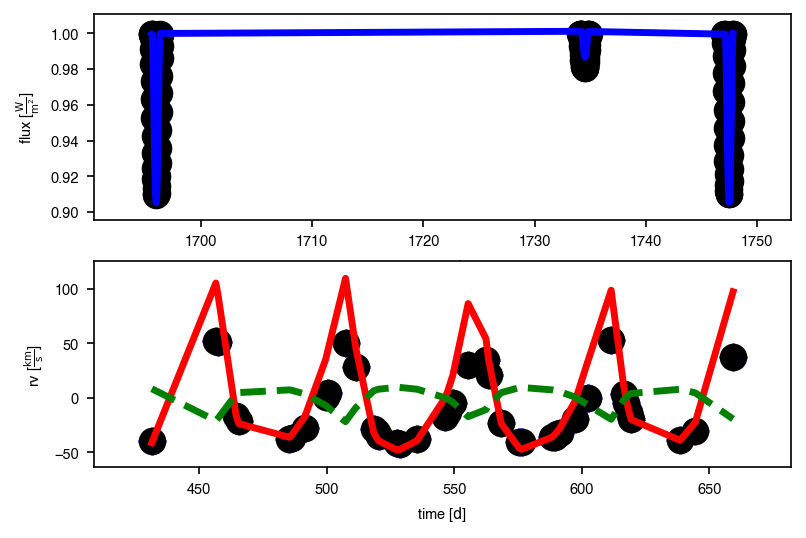

(<autofig.figure.Figure | 2 axes | 6 call(s)>,
 <Figure size 900x600 with 2 Axes>)

In [78]:
b.plot(show=True)

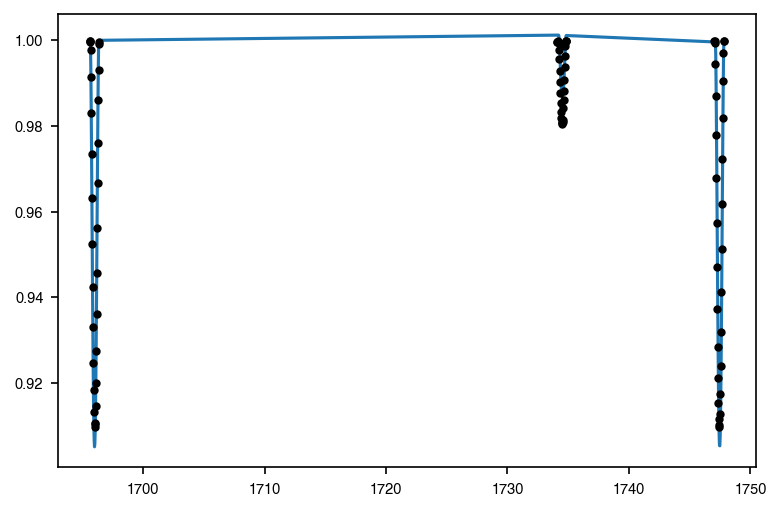

In [79]:
plt.plot(full_transit_time, flux)
plt.plot(full_transit_time, full_transit_flux,'.k')

In [ ]:
'fluxes@full_lc@phoebe01@latest@lc@model'

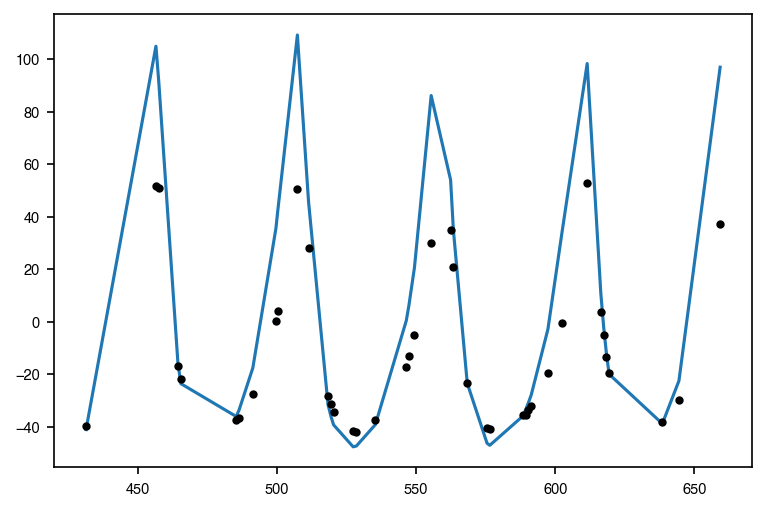

In [80]:
plt.plot(rv_time, b['full_rv@model@primary@rvs@latest'].value)
plt.plot(rv_time, rv_rv,'.k')

In [11]:
from __future__ import print_function, division

import warnings

import numpy as np
from phoebe import Bundle
import phoebe

class Phoetter(Bundle):

    def __init__(self):
        # Speedups
        phoebe.interactive_constraints_off()
        self.get_parameter(context='compute', qualifier='irrad_method').set_value("none")
        self.get_parameter(context='compute', component='primary', qualifier='ntriangles').set_value(300)
        self.get_parameter(context='compute', component='secondary', qualifier='ntriangles').set_value(300)
        
        # Add some fitting constraints
        self.add_constraint('requivratio')
        self.add_constraint('requivsum')
        self.add_constraint('teffratio')

        # And flip them
        self.flip_constraint('requivratio', solve_for='requiv@primary')
        self.flip_constraint('requivsum', solve_for='requiv@secondary')
        self.flip_constraint('teffratio', solve_for='teff@secondary@component')
        self.flip_constraint('esinw', solve_for='ecc')
        self.flip_constraint('ecosw', solve_for='per0')

    @staticmethod
    def from_bundle(bundle):
        pass

    def model(self, params, twigs, time, interp=False):
        """
        Our model, takes in an array of parameter values, their corresponding twigs (sue me)
        in Phoebe, and a bundle object, and returns the flux at those values.
        """
        # Iterate over pairs of parameter and twig values, assigning them to the bundle
        for param, twig in zip(params, twigs):
            self[twig] = param
        
        self.run_compute()
        
        if interp:
            return self['fluxes@latest@model'].interp_value(times=time)
        else:
            return self['fluxes@latest@model'].get_value()

    def lnlike(self, params, twigs, time, flux, flux_err):
        try:
            model_flux = model(params, twigs, bundle, time)
            return -0.5 * np.sum((flux - model_flux)**2 / flux_err**2)
        except:
            # Here we catch overflows in the model. This is a cheap prior that should be implemented properly
            return -np.inf

    def sort_flux(time, period, flux):
        fold_time = time % period / period
        sort = np.argsort(fold_time)
        return fold_time[sort], flux[sort]


In [13]:
def model(param_values):
    (incl, q, esinw, ecosw, rsum, rratio, tratio, t1) = param_values
    
    '''
    If some of the values are outside of the physical parameter space,
    setting the parameters or running compute will fail, so we need to catch
    and penalize those cases. Because some algorithms don't handle nans or infs
    we'll just use an arbitrarily large number. (1e12 in this case)
    '''
    
    try:
        b['esinw'] = esinw
        b['ecosw'] = ecosw
        b['incl@binary'] = incl
        b['q'] = q
        b['requiv@primary'] = b['value@sma@binary']*rsum/(1.+rratio)
        b['requiv@secondary'] = b['value@sma@binary']*rsum*rratio/(1.+rratio)
        b['teff@primary'] = t1 
        b['teff@secondary'] = tratio*b['value@teff@primary']
        # b['pblum'] = pblum
        # b['l3'] = l3

        b.run_compute(irrad_method='none')
        fluxes_model = b['fluxes@model'].get_value()#(times=full_transit_time)
        return fluxes_model
    except:
        return np.inf
    
def chi2(param_values):
#     (incl, q,esinw, ecosw, rsum, rratio, tratio, t) = param_values
    
    '''
    If some of the values are outside of the physical parameter space,
    setting the parameters or running compute will fail, so we need to catch
    and penalize those cases. Because some algorithms don't handle nans or infs
    we'll just use an arbitrarily large number. (1e12 in this case)
    '''
    print(param_values)
    fluxes_model = model(param_values)
    chi2 = 0.5*np.sum((fluxes_model-b['value@fluxes@full_lc@dataset'])**2 / 1**2 )
    return chi2

In [14]:
x0 = [8.70000000e+01, 0.92, 1.58200000e-01, 3.95530000e-01, 6.67547942e-02,
       3.20000000e-01, 8.00000000e-01, 10100]
flux = model(x0)

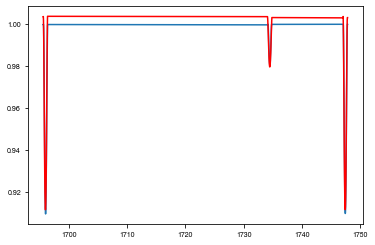

In [15]:
%matplotlib inline
plt.plot(full_transit_time, full_transit_flux)
plt.plot(full_transit_time, flux, c='r')


In [16]:
b['requiv@primary']

<Parameter: requiv=4.426928639062081 solRad | keys: description, value, quantity, default_unit, limits, visible_if, copy_for, advanced>

In [17]:
b['requiv@primary'], b['requiv@secondary']

(<Parameter: requiv=4.426928639062081 solRad | keys: description, value, quantity, default_unit, limits, visible_if, copy_for, advanced>,
 <Parameter: requiv=1.4166171644998657 solRad | keys: description, value, quantity, default_unit, limits, visible_if, copy_for, advanced>)

In [62]:
from scipy.optimize import minimize

# Run the minimizer
res_nms = minimize(chi2, x0,
                   method='Nelder-Mead', tol=100
                  )

[8.70000000e+01 9.20000000e-01 1.58200000e-01 3.95530000e-01
 6.67547942e-02 3.20000000e-01 8.00000000e-01 1.01000000e+04]
[9.13500000e+01 9.20000000e-01 1.58200000e-01 3.95530000e-01
 6.67547942e-02 3.20000000e-01 8.00000000e-01 1.01000000e+04]
[8.70000000e+01 9.66000000e-01 1.58200000e-01 3.95530000e-01
 6.67547942e-02 3.20000000e-01 8.00000000e-01 1.01000000e+04]
[8.70000000e+01 9.20000000e-01 1.66110000e-01 3.95530000e-01
 6.67547942e-02 3.20000000e-01 8.00000000e-01 1.01000000e+04]
[8.70000000e+01 9.20000000e-01 1.58200000e-01 4.15306500e-01
 6.67547942e-02 3.20000000e-01 8.00000000e-01 1.01000000e+04]
[8.70000000e+01 9.20000000e-01 1.58200000e-01 3.95530000e-01
 7.00925339e-02 3.20000000e-01 8.00000000e-01 1.01000000e+04]
[8.70000000e+01 9.20000000e-01 1.58200000e-01 3.95530000e-01
 6.67547942e-02 3.36000000e-01 8.00000000e-01 1.01000000e+04]
[8.70000000e+01 9.20000000e-01 1.58200000e-01 3.95530000e-01
 6.67547942e-02 3.20000000e-01 8.40000000e-01 1.01000000e+04]
[8.70000000e+01 

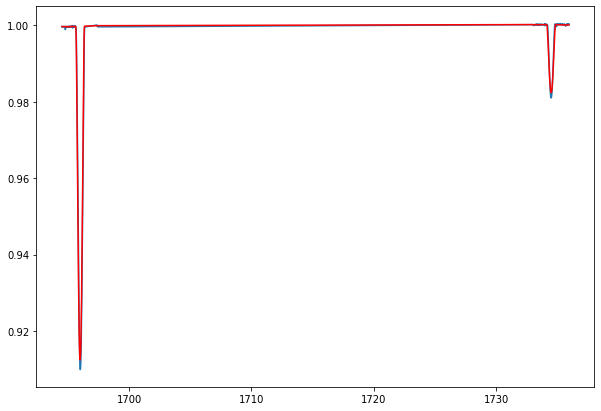

In [63]:
plt.figure(figsize=[10,7])

x0 = res_nms.x
flux = model(x0)

plt.plot(full_transit_time, full_transit_flux)
plt.plot(full_transit_time, flux, c='r')

In [64]:
res_nms

 final_simplex: (array([[8.68663342e+01, 9.24584649e-01, 1.61285902e-01, 3.94363325e-01,
        6.65722266e-02, 3.23674077e-01, 7.83962309e-01, 1.01605760e+04],
       [8.69077056e+01, 9.25462705e-01, 1.61286001e-01, 3.94251211e-01,
        6.63087223e-02, 3.25424565e-01, 7.86843201e-01, 1.00941798e+04],
       [8.68475333e+01, 9.23859113e-01, 1.61052721e-01, 3.94273617e-01,
        6.66362748e-02, 3.26369345e-01, 7.78636167e-01, 1.01474486e+04],
       [8.68735295e+01, 9.26706731e-01, 1.60813284e-01, 3.94594375e-01,
        6.64794504e-02, 3.24108193e-01, 7.86655594e-01, 1.01294169e+04],
       [8.68924052e+01, 9.22861999e-01, 1.60721522e-01, 3.94466932e-01,
        6.64725435e-02, 3.25283587e-01, 7.86536357e-01, 1.01630328e+04],
       [8.68791842e+01, 9.25700714e-01, 1.61034493e-01, 3.94556437e-01,
        6.67701487e-02, 3.24821382e-01, 7.78388786e-01, 1.01516886e+04],
       [8.68905443e+01, 9.29803686e-01, 1.59885808e-01, 3.94682083e-01,
        6.64687349e-02, 3.23409978e-01, 7

In [18]:
rsum, rratio = 6.65722266e-02, 3.23674077e-01

rsum/(1.+rratio), rsum*rratio/(1.+rratio)

(0.05029351843988708, 0.01627870816011293)

In [19]:
0.05029351843988708*43

2.1626212929151443

In [20]:
b['requiv@secondary']

<Parameter: requiv=1.4166171644998657 solRad | keys: description, value, quantity, default_unit, limits, visible_if, copy_for, advanced>

In [21]:
rsum, rratio = 6.67547942e-02, 3.20000000e-01

b['value@sma@binary']*rsum/(1.+rratio),b['value@sma@binary']*rsum*rratio/(1.+rratio)

(4.426928639062081, 1.4166171644998657)

In [22]:
0.26803061307575754 * 46.293/np.sin(np.degrees(87))

14.993643683786459

In [23]:
phoebe.mpi_off()

In [24]:
def model(params, x):
    (incl, q, esinw, ecosw, rsum, rratio, tratio) = params
    b['esinw'] = esinw
    b['ecosw'] = ecosw
    b['incl@binary'] = incl
    b['q'] = q
    b['requiv@primary'] = b['value@sma@binary']*rsum/(1.+rratio)
    b['requiv@secondary'] = b['value@sma@binary']*rsum*rratio/(1.+rratio)
    # b['teff@primary'] = teff1 
    b['teff@secondary'] = tratio*b['value@teff@primary']
    # b['pblum'] = pblum
    # b['l3'] = l3

    b.run_compute(irrad_method='none')
    fluxes_model = b['fluxes@model'].get_value()#interp_value(times=lcdata[:,0])
    return fluxes_model

def lnprior(params):
    (incl, q, esinw, ecosw, rsum, rratio, tratio) = params
    if (85 < incl < 90) & (q < 1):
        return 0.
    else:
        return -np.inf
    
def lnlike(params, x, y, yerr):
    lp = lnprior(params)
    if not np.isfinite(lp):
        return -np.inf
    try:
        model_flux = model(params, x)
        return -0.5 * np.sum((y - model_flux)**2 / 1**2)
    except:
        return -np.inf

In [25]:
b['value@sma@binary']

87.53747013367239

In [50]:
params = [8.70000000e+01, 9.20000000e-01, 1.58200000e-01, 3.95530000e-01,
       6.67547942e-02, 3.20000000e-01, 8.40000000e-01]
#plt.plot(full_transit_time, model(params, full_transit_time))
cc = model(params, full_transit_time)

Text(0, 0.5, 'Flux')

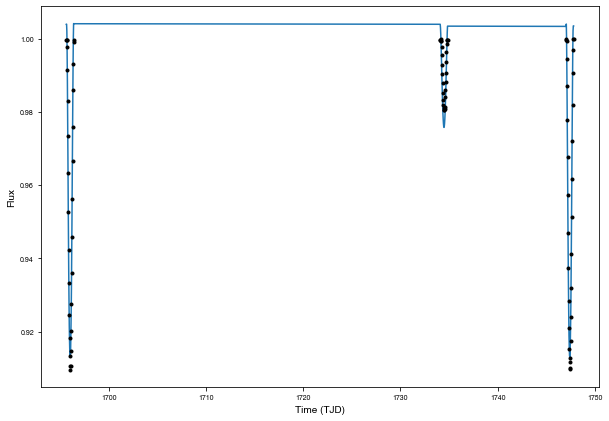

In [51]:
plt.figure(figsize=[10,7])

plt.plot(full_transit_time, cc)
plt.plot(full_transit_time, full_transit_flux, '.k')
plt.xlabel('Time (TJD)')
plt.ylabel('Flux')

In [ ]:
import dynesty as dn

def ptransform(u):
    # params = [incl', 'q', 'esinw', 'ecosw', 'r1+r2', 'r2/r1', 'teff1', 'tratio', 'pblum', 'l3']
    bounds = np.array([[80.,90.],[0.5, 2], [0.05, 0.3],[0.,0.5],[-0.1,0.1], [0.1,1.], [0.5,1.]])
    
    x = np.array(u)
    
    for i,bound in enumerate(bounds):
        x[i] = (bound[1] - bound[0])*u[i] + bound[0]
        
    return x
    

ndim = 7

# "Dynamic" nested sampling.
dsampler = dn.DynamicNestedSampler(loglike, ptransform, ndim)
dsampler.run_nested(maxiter=20000)

0it [00:00, ?it/s]

[89.70254891  1.86457736  0.10372944  0.11880846  0.09510577  0.22358796
  0.62847734] <function chi2 at 0x7f473155c1e0>
[8.72530798e+01 1.33250928e+00 1.64703475e-01 4.54957720e-01
 1.86906557e-02 6.84852818e-01 6.83322526e-01] <function chi2 at 0x7f473155c1e0>
[8.78267090e+01 1.49531261e+00 5.98870861e-02 1.79188987e-01
 8.47906830e-02 3.47039985e-01 6.21815259e-01] <function chi2 at 0x7f473155c1e0>
[8.13645756e+01 1.04036335e+00 2.44651779e-01 1.14598333e-01
 1.18715379e-02 9.38622172e-01 8.46476860e-01] <function chi2 at 0x7f473155c1e0>
[8.04878281e+01 5.16515459e-01 2.98548351e-01 2.92374099e-01
 7.14738049e-02 1.65749296e-01 5.83355771e-01] <function chi2 at 0x7f473155c1e0>
[8.54469056e+01 1.06482814e+00 1.35946288e-01 4.86683684e-02
 8.70965045e-02 8.24480763e-01 9.50348053e-01] <function chi2 at 0x7f473155c1e0>
[8.56389279e+01 9.94728237e-01 1.98082675e-01 1.28736224e-01
 6.15114227e-02 5.81005408e-01 7.29806237e-01] <function chi2 at 0x7f473155c1e0>
[8.49448036e+01 1.55106431e